# EfficientNet-B3 Food Classification - Optimized Training
Train EfficientNet-B3 on splits_new_v2 dataset with:
- Strong augmentation and regularization for maximum val accuracy
- Comprehensive evaluation and metrics
- ONNX export with class names

In [1]:
%matplotlib inline
import os, time, json, csv, random, datetime
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch_directml
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
dml = torch_directml.device()
print("Using device:", dml)

Using device: privateuseone:0


In [2]:
# Paths and hyperparameters - optimized for max val accuracy
root_dir = r"d:\VSC FILES\testtrain\food_not_food_ds"
assert os.path.isdir(root_dir), f"Dataset not found: {root_dir}"

model_name = "efficientnet_b3"
use_pretrained = True

# Optimized hyperparams
image_size = 252  # native image size from dataset
epochs = 20
batch_size = 16
lr = 1e-3
weight_decay = 1e-4
num_workers = 0
print_every = 50

# Regularization
label_smoothing = 0.1
dropout_p = 0.3
mixup_alpha = 0.2
head_warmup_epochs = 3

# Early stopping
patience = 15  # stop if no improvement for 15 epochs

run_root = os.path.join(os.path.dirname(root_dir), "runs")
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_dir = os.path.join(run_root, f"efficientnet_b3_optimized-{ts}")
os.makedirs(run_dir, exist_ok=True)
print(f"Run directory: {run_dir}")

Run directory: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113


In [3]:
# Dataset and DataLoaders with strong augmentation
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
])

eval_tfms = transforms.Compose([
    transforms.Resize(image_size + 32),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

class SplitDataset(Dataset):
    def __init__(self, root, split, transform=None, classes=None, class_to_idx=None):
        self.root = root
        self.split = split
        self.transform = transform
        if classes is None or class_to_idx is None:
            classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
            class_to_idx = {c: i for i, c in enumerate(classes)}
        self.classes = classes
        self.class_to_idx = class_to_idx
        samples = []
        for cls in self.classes:
            split_dir = os.path.join(root, cls, split)
            if not os.path.isdir(split_dir):
                continue
            for dp, _, fns in os.walk(split_dir):
                for fn in fns:
                    if fn.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
                        samples.append((os.path.join(dp, fn), self.class_to_idx[cls]))
        if not samples:
            raise RuntimeError(f"No images for split='{split}' under {root}")
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = SplitDataset(root_dir, 'train', transform=train_tfms)
val_ds = SplitDataset(root_dir, 'val', transform=eval_tfms, classes=train_ds.classes, class_to_idx=train_ds.class_to_idx)
test_ds = SplitDataset(root_dir, 'test', transform=eval_tfms, classes=train_ds.classes, class_to_idx=train_ds.class_to_idx)
num_classes = len(train_ds.classes)
print(f"Classes: {num_classes} | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_eval_ds = SplitDataset(root_dir, 'train', transform=eval_tfms, classes=train_ds.classes, class_to_idx=train_ds.class_to_idx)
train_eval_loader = DataLoader(train_eval_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Save class names
with open(os.path.join(run_dir, 'class_names.json'), 'w') as f:
    json.dump(train_ds.classes, f, indent=2)
print(f"Saved class names to {os.path.join(run_dir, 'class_names.json')}")

Classes: 2 | train=9528 val=248 test=248
Saved class names to d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\class_names.json


In [4]:
# Model setup
weights = models.EfficientNet_B3_Weights.DEFAULT if use_pretrained else None
model = models.efficientnet_b3(weights=weights)
in_f = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_p),
    nn.Linear(in_f, num_classes)
)
model = model.to(dml)

criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Freeze backbone for warmup
for name, p in model.named_parameters():
    if 'classifier' not in name:
        p.requires_grad = False

optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params/1e6:.2f}M | Trainable: {trainable_params/1e6:.2f}M")

Total params: 10.70M | Trainable: 0.00M


In [ ]:
# Metrics and utilities
def topk_accuracy(logits, targets, topk=(1,)):
    maxk = max(topk)
    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append((correct_k.item() / targets.size(0)) * 100.0)
    return res

class AvgMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.sum = 0.0
        self.n = 0
    @property
    def avg(self):
        return self.sum / max(1, self.n)
    def update(self, val, n=1):
        self.sum += float(val) * n
        self.n += n

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, None, 1.0
    lam = float(np.random.beta(alpha, alpha))
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1.0 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

log_csv = os.path.join(run_dir, "metrics_epoch.csv")
log_jsonl = os.path.join(run_dir, "metrics_epoch.jsonl")
history = []

In [6]:
# Training and evaluation functions
def train_one_epoch(epoch):
    model.train()
    loss_m, top1_m = AvgMeter(), AvgMeter()
    t0 = time.perf_counter()
    n_seen = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(dml)
        labels = labels.to(dml)
        optimizer.zero_grad(set_to_none=True)
        
        if mixup_alpha > 0:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            y_a = y_a.to(dml)
            y_b = y_b.to(dml)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        bsz = labels.size(0)
        n_seen += bsz
        top1 = topk_accuracy(outputs, labels, (1,))[0]
        loss_m.update(loss.item(), bsz)
        top1_m.update(top1, bsz)
        
        if (i + 1) % print_every == 0 or (i + 1) == len(train_loader):
            dt = time.perf_counter() - t0
            ips = n_seen / max(1e-6, dt)
            print(f"Epoch {epoch:02d} | batch {i+1}/{len(train_loader)} | loss {loss_m.avg:.4f} | top1 {top1_m.avg:.2f}% | {ips:.1f} img/s")
    return {"loss": loss_m.avg, "top1": top1_m.avg}

def evaluate(loader):
    model.eval()
    loss_m, top1_m = AvgMeter(), AvgMeter()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(dml)
            labels = labels.to(dml)
            outputs = model(images)
            loss = criterion(outputs, labels)
            top1 = topk_accuracy(outputs, labels, (1,))[0]
            bsz = labels.size(0)
            loss_m.update(loss.item(), bsz)
            top1_m.update(top1, bsz)
    return {"loss": loss_m.avg, "top1": top1_m.avg}

def log_epoch(row):
    write_header = not os.path.exists(log_csv)
    with open(log_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if write_header:
            w.writeheader()
        w.writerow(row)
    with open(log_jsonl, "a") as f:
        f.write(json.dumps(row) + "\n")

In [7]:
# Training loop with early stopping
best_acc = 0.0
best_path = os.path.join(run_dir, f"best_{model_name}.pth")
no_improve_count = 0

for epoch in range(1, epochs + 1):
    # Unfreeze after warmup
    if epoch == head_warmup_epochs + 1:
        print(f"\n=== Unfreezing backbone at epoch {epoch} ===")
        for name, p in model.named_parameters():
            p.requires_grad = True
        optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr/10, weight_decay=weight_decay)
        remaining = max(1, epochs - epoch + 1)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=remaining)
    
    t0 = time.perf_counter()
    tr = train_one_epoch(epoch)
    tr_clean = evaluate(train_eval_loader)
    va = evaluate(val_loader)
    scheduler.step()
    dt = time.perf_counter() - t0
    
    row = {
        "epoch": epoch,
        "train_loss": round(tr["loss"], 6),
        "train_top1": round(tr["top1"], 4),
        "train_eval_loss": round(tr_clean["loss"], 6),
        "train_eval_top1": round(tr_clean["top1"], 4),
        "val_loss": round(va["loss"], 6),
        "val_top1": round(va["top1"], 4),
        "time_s": round(dt, 3)
    }
    history.append(row)
    log_epoch(row)
    
    print(f"\nEpoch {epoch:02d}/{epochs} | {dt:.1f}s")
    print(f"  Train(mixup): loss {tr['loss']:.4f} | top1 {tr['top1']:.2f}%")
    print(f"  Train(clean): loss {tr_clean['loss']:.4f} | top1 {tr_clean['top1']:.2f}%")
    print(f"  Val:          loss {va['loss']:.4f} | top1 {va['top1']:.2f}%")
    
    # Save best model
    if va["top1"] > best_acc:
        best_acc = va["top1"]
        no_improve_count = 0
        torch.save({
            "model_name": model_name,
            "model_state": model.state_dict(),
            "classes": train_ds.classes,
            "image_size": image_size,
            "mean": mean,
            "std": std,
            "epoch": epoch,
            "val_top1": va["top1"]
        }, best_path)
        print(f"  ✓ Saved new best: {best_path} (val Top-1={best_acc:.2f}%)")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"\n[Early Stop] No improvement for {patience} epochs. Stopping.")
            break

print(f"\n=== Training Complete ===")
print(f"Best val Top-1: {best_acc:.2f}%")
print(f"Best model saved to: {best_path}")

c:\Users\JP\anaconda3\envs\dml\Lib\site-packages\torch\optim\adamw.py:529: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


Epoch 01 | batch 50/596 | loss 0.4977 | top1 65.38% | 45.1 img/s
Epoch 01 | batch 100/596 | loss 0.4475 | top1 70.56% | 47.5 img/s
Epoch 01 | batch 150/596 | loss 0.4368 | top1 72.50% | 48.9 img/s
Epoch 01 | batch 200/596 | loss 0.4259 | top1 72.09% | 49.7 img/s
Epoch 01 | batch 250/596 | loss 0.4165 | top1 72.53% | 49.9 img/s
Epoch 01 | batch 300/596 | loss 0.4124 | top1 72.00% | 50.2 img/s
Epoch 01 | batch 350/596 | loss 0.4092 | top1 71.57% | 50.4 img/s
Epoch 01 | batch 400/596 | loss 0.4112 | top1 70.94% | 50.5 img/s
Epoch 01 | batch 450/596 | loss 0.4073 | top1 71.18% | 50.6 img/s
Epoch 01 | batch 500/596 | loss 0.4073 | top1 71.38% | 50.6 img/s
Epoch 01 | batch 550/596 | loss 0.4074 | top1 71.91% | 50.7 img/s
Epoch 01 | batch 596/596 | loss 0.4064 | top1 72.08% | 50.7 img/s

Epoch 01/20 | 261.4s
  Train(mixup): loss 0.4064 | top1 72.08%
  Train(clean): loss 0.2885 | top1 97.04%
  Val:          loss 0.2890 | top1 95.56%
  ✓ Saved new best: d:\VSC FILES\testtrain\runs\efficientnet_

Saved training curves to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\training_curves.png


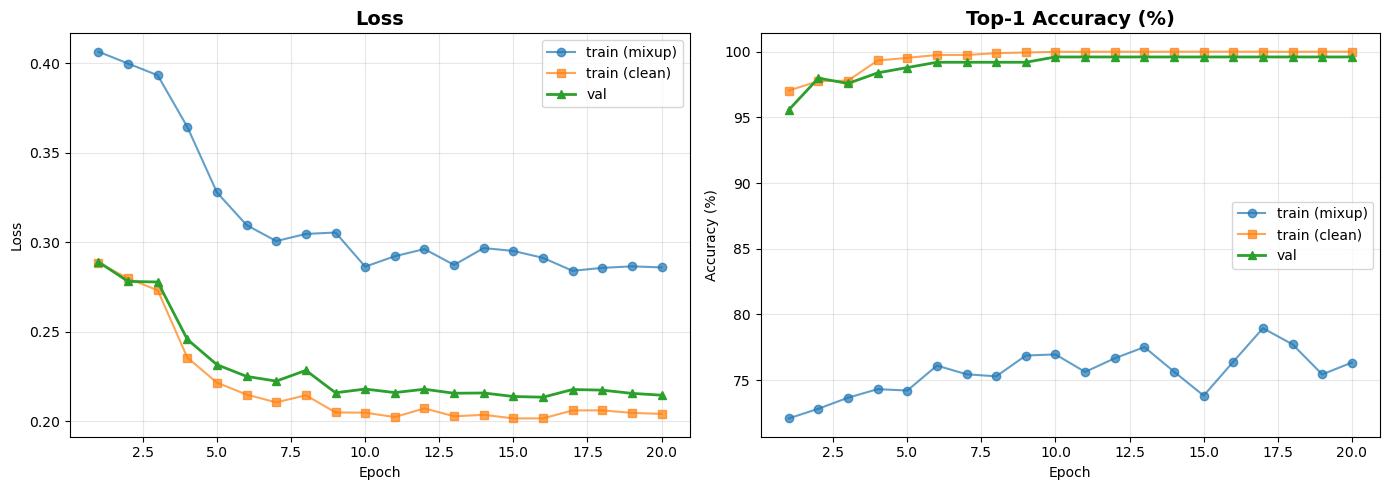

In [9]:
# Plot training curves
epochs_ = [h["epoch"] for h in history]
tr_loss = [h["train_loss"] for h in history]
va_loss = [h["val_loss"] for h in history]
tr_eval_loss = [h["train_eval_loss"] for h in history]
tr_t1 = [h["train_top1"] for h in history]
va_t1 = [h["val_top1"] for h in history]
tr_eval_t1 = [h["train_eval_top1"] for h in history]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(epochs_, tr_loss, '-o', label='train (mixup)', alpha=0.7)
axes[0].plot(epochs_, tr_eval_loss, '-s', label='train (clean)', alpha=0.7)
axes[0].plot(epochs_, va_loss, '-^', label='val', linewidth=2)
axes[0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Top-1 Accuracy
axes[1].plot(epochs_, tr_t1, '-o', label='train (mixup)', alpha=0.7)
axes[1].plot(epochs_, tr_eval_t1, '-s', label='train (clean)', alpha=0.7)
axes[1].plot(epochs_, va_t1, '-^', label='val', linewidth=2)
axes[1].set_title('Top-1 Accuracy (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, "training_curves.png"), dpi=150, bbox_inches='tight')
print(f"Saved training curves to: {os.path.join(run_dir, 'training_curves.png')}")
plt.show()

In [10]:
# Load best model and evaluate on all splits
print("\n=== Loading Best Model ===")
ckpt = torch.load(best_path, map_location="cpu")
classes = ckpt["classes"]

test_model = models.efficientnet_b3(weights=None)
test_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_p),
    nn.Linear(test_model.classifier[1].in_features, len(classes))
)
test_model.load_state_dict(ckpt["model_state"])
test_model = test_model.to(dml).eval()

print(f"Loaded best model from epoch {ckpt['epoch']}")
print(f"Best val Top-1: {ckpt['val_top1']:.2f}%")

def evaluate_detailed(model, loader, split_name):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(dml)
            labels = labels.to(dml)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    # Top-1 predictions
    top1_probs, top1_preds = all_probs.max(dim=1)
    top1_correct = (top1_preds == all_labels).float()
    top1_acc = top1_correct.mean().item() * 100

    # Count samples with top1 confidence >= 80%
    top1_high_conf = (top1_probs >= 0.8).sum().item()
    top1_high_conf_correct = ((top1_probs >= 0.8) & (top1_preds == all_labels)).sum().item()

    # Calculate additional metrics: accuracy, F1, precision, recall
    y_true = all_labels.numpy()
    y_pred = top1_preds.numpy()

    accuracy = accuracy_score(y_true, y_pred) * 100
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0) * 100
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100

    print(f"\n{split_name.upper()} Results:")
    print(f"  Total samples: {len(all_labels)}")
    print(f"  Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"  Accuracy (sklearn): {accuracy:.2f}%")
    print(f"  F1 Score (macro): {f1_macro:.2f}%")
    print(f"  F1 Score (weighted): {f1_weighted:.2f}%")
    print(f"  Precision (macro): {precision_macro:.2f}%")
    print(f"  Precision (weighted): {precision_weighted:.2f}%")
    print(f"  Recall (macro): {recall_macro:.2f}%")
    print(f"  Recall (weighted): {recall_weighted:.2f}%")
    print(f"  Top-1 with ≥80% confidence: {top1_high_conf} ({top1_high_conf/len(all_labels)*100:.2f}%)")
    print(f"    └─ Correct among high-conf: {top1_high_conf_correct} ({top1_high_conf_correct/max(1,top1_high_conf)*100:.2f}%)")

    return {
        "split": split_name,
        "total": len(all_labels),
        "top1_acc": top1_acc,
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "top1_conf80_count": top1_high_conf,
        "top1_conf80_correct": top1_high_conf_correct,
        "all_probs": all_probs,
        "all_labels": all_labels,
        "all_preds": top1_preds
    }

train_results = evaluate_detailed(test_model, train_eval_loader, "train")
val_results = evaluate_detailed(test_model, val_loader, "val")
test_results = evaluate_detailed(test_model, test_loader, "test")


=== Loading Best Model ===


C:\Users\JP\AppData\Local\Temp\ipykernel_21920\2972520915.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location="cpu")


Loaded best model from epoch 10
Best val Top-1: 99.60%

TRAIN Results:
  Total samples: 9528
  Top-1 Accuracy: 99.99%
  Accuracy (sklearn): 99.99%
  F1 Score (macro): 99.99%
  F1 Score (weighted): 99.99%
  Precision (macro): 99.99%
  Precision (weighted): 99.99%
  Recall (macro): 99.99%
  Recall (weighted): 99.99%
  Top-1 with ≥80% confidence: 9482 (99.52%)
    └─ Correct among high-conf: 9482 (100.00%)

VAL Results:
  Total samples: 248
  Top-1 Accuracy: 99.60%
  Accuracy (sklearn): 99.60%
  F1 Score (macro): 99.60%
  F1 Score (weighted): 99.60%
  Precision (macro): 99.60%
  Precision (weighted): 99.60%
  Recall (macro): 99.60%
  Recall (weighted): 99.60%
  Top-1 with ≥80% confidence: 243 (97.98%)
    └─ Correct among high-conf: 242 (99.59%)

TEST Results:
  Total samples: 248
  Top-1 Accuracy: 99.19%
  Accuracy (sklearn): 99.19%
  F1 Score (macro): 99.19%
  F1 Score (weighted): 99.19%
  Precision (macro): 99.21%
  Precision (weighted): 99.21%
  Recall (macro): 99.19%
  Recall (weight

In [11]:
# Per-class accuracy analysis
def per_class_accuracy(all_probs, all_labels, classes):
    num_classes = len(classes)
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)
    
    preds = all_probs.argmax(dim=1)
    for label, pred in zip(all_labels, preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1
    
    class_acc = (class_correct / class_total.clamp(min=1)) * 100
    
    # Sort by accuracy
    sorted_indices = torch.argsort(class_acc, descending=True)
    
    return class_acc, class_total, sorted_indices

print("\n=== Per-Class Accuracy (Test Set) ===")
class_acc, class_total, sorted_idx = per_class_accuracy(
    test_results["all_probs"],
    test_results["all_labels"],
    classes
)

# Top 10 best classes
print("\nTop 10 Best Classes:")
for i in range(min(10, len(classes))):
    idx = sorted_idx[i]
    print(f"  {i+1}. {classes[idx]}: {class_acc[idx]:.2f}% ({int(class_total[idx])} samples)")

# Bottom 10 worst classes
print("\nBottom 10 Worst Classes:")
for i in range(min(10, len(classes))):
    idx = sorted_idx[-(i+1)]
    print(f"  {i+1}. {classes[idx]}: {class_acc[idx]:.2f}% ({int(class_total[idx])} samples)")

# Save per-class results
per_class_results = []
for i in range(len(classes)):
    per_class_results.append({
        "class": classes[i],
        "accuracy": float(class_acc[i]),
        "total": int(class_total[i])
    })

with open(os.path.join(run_dir, "per_class_accuracy.json"), "w") as f:
    json.dump(per_class_results, f, indent=2)
print(f"\nSaved per-class accuracy to: {os.path.join(run_dir, 'per_class_accuracy.json')}")


=== Per-Class Accuracy (Test Set) ===

Top 10 Best Classes:
  1. food: 100.00% (124 samples)
  2. not_food: 98.39% (124 samples)

Bottom 10 Worst Classes:
  1. not_food: 98.39% (124 samples)
  2. food: 100.00% (124 samples)

Saved per-class accuracy to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\per_class_accuracy.json


Saved per-class accuracy chart to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\per_class_accuracy.png


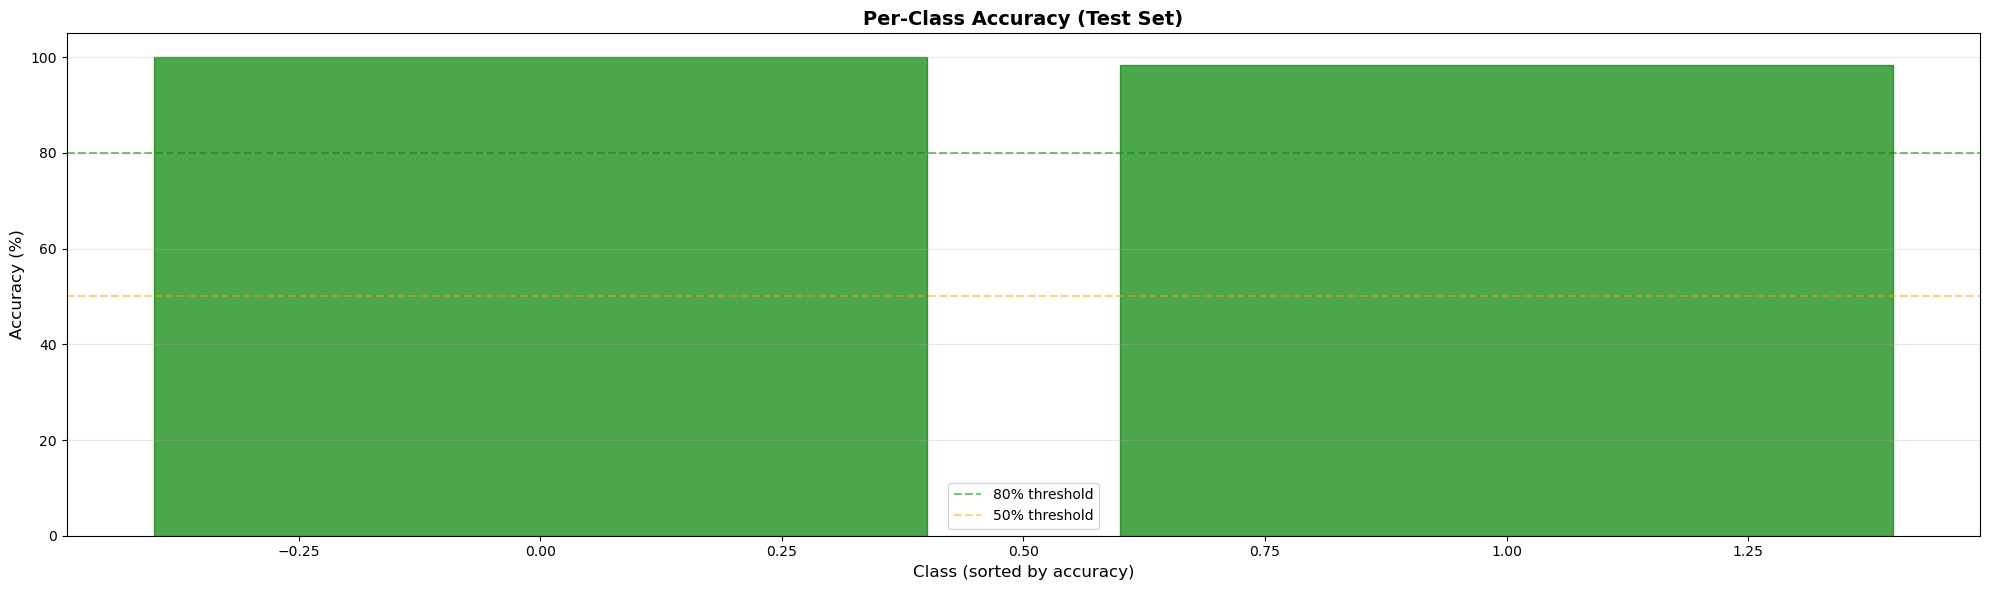

In [12]:
# Visualize per-class accuracy
fig, ax = plt.subplots(figsize=(20, 6))
class_names_sorted = [classes[i] for i in sorted_idx]
acc_sorted = [class_acc[i].item() for i in sorted_idx]

bars = ax.bar(range(len(classes)), acc_sorted, color='steelblue', alpha=0.7)

# Color code: green for >80%, yellow for 50-80%, red for <50%
for i, (bar, acc) in enumerate(zip(bars, acc_sorted)):
    if acc >= 80:
        bar.set_color('green')
    elif acc >= 50:
        bar.set_color('orange')
    else:
        bar.set_color('red')

ax.set_xlabel('Class (sorted by accuracy)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy (Test Set)', fontsize=14, fontweight='bold')
ax.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, "per_class_accuracy.png"), dpi=150, bbox_inches='tight')
print(f"Saved per-class accuracy chart to: {os.path.join(run_dir, 'per_class_accuracy.png')}")
plt.show()


=== Top 10 Most Confused Class Pairs ===
  1. not_food → food: 2 times

Saved confusion matrix to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\confusion_matrix.png


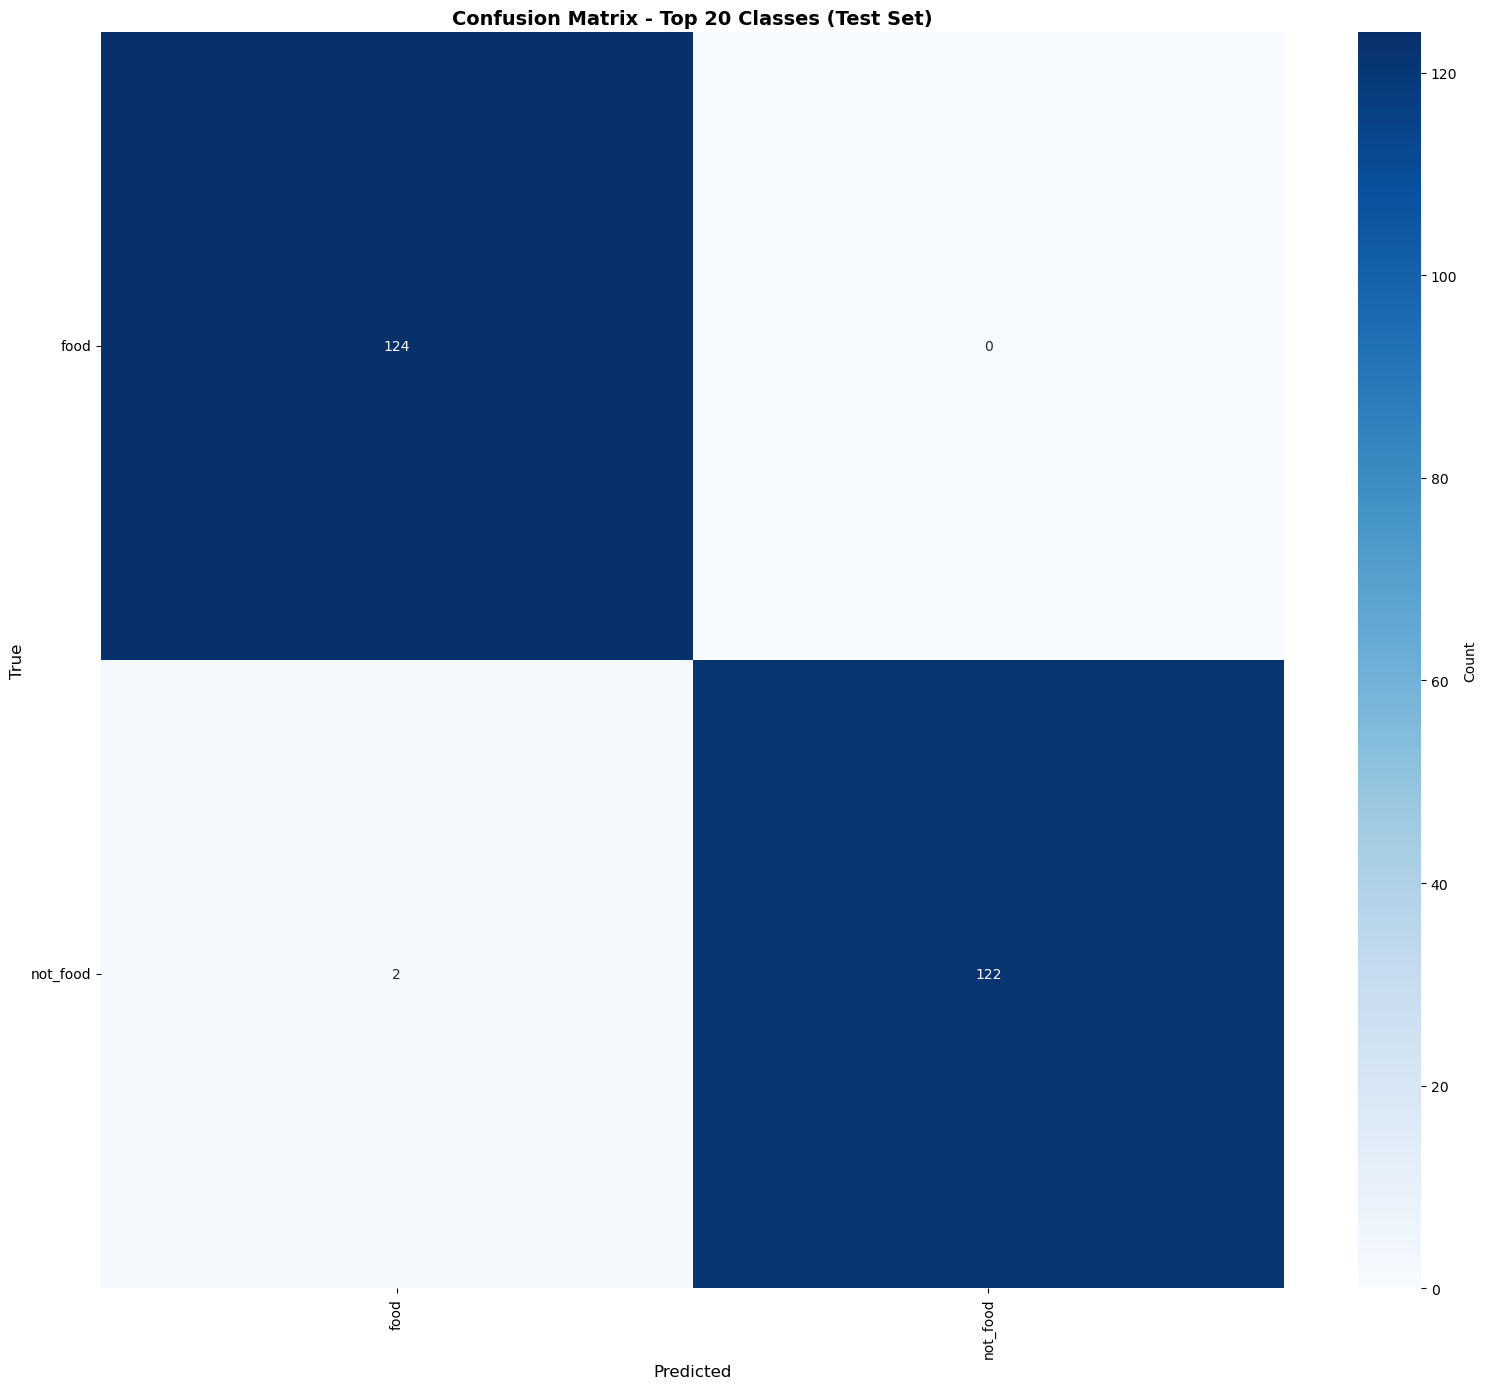

In [13]:
# Confusion matrix for top confusing classes
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
preds = test_results["all_probs"].argmax(dim=1).numpy()
labels = test_results["all_labels"].numpy()

# Full confusion matrix
cm = confusion_matrix(labels, preds)

# Find most confused pairs
confused_pairs = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("\n=== Top 10 Most Confused Class Pairs ===")
for i, (true_idx, pred_idx, count) in enumerate(confused_pairs[:10], 1):
    print(f"  {i}. {classes[true_idx]} → {classes[pred_idx]}: {count} times")

# Plot confusion matrix for top 20 classes
top_n = 20
top_classes_idx = sorted_idx[:top_n].tolist()
cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]
class_names_subset = [classes[i] for i in top_classes_idx]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_subset, yticklabels=class_names_subset,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix - Top {top_n} Classes (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(run_dir, "confusion_matrix.png"), dpi=150, bbox_inches='tight')
print(f"\nSaved confusion matrix to: {os.path.join(run_dir, 'confusion_matrix.png')}")
plt.show()

In [14]:
# Detailed classification report
print("\n=== Classification Report (Test Set) ===")
y_true = test_results["all_labels"].numpy()
y_pred = test_results["all_preds"].numpy()

# Full classification report
report = classification_report(y_true, y_pred, target_names=classes, digits=4, zero_division=0)
print(report)

# Save classification report
report_path = os.path.join(run_dir, "classification_report.txt")
with open(report_path, "w") as f:
    f.write("Classification Report (Test Set)\n")
    f.write("="*80 + "\n\n")
    f.write(report)
print(f"\nSaved classification report to: {report_path}")

# Generate per-class metrics
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
per_class_metrics = []
for class_name in classes:
    if class_name in report_dict:
        metrics = report_dict[class_name]
        per_class_metrics.append({
            "class": class_name,
            "precision": metrics["precision"] * 100,
            "recall": metrics["recall"] * 100,
            "f1_score": metrics["f1-score"] * 100,
            "support": metrics["support"]
        })

# Save per-class metrics
metrics_path = os.path.join(run_dir, "per_class_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(per_class_metrics, f, indent=2)
print(f"Saved per-class metrics to: {metrics_path}")


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

        food     0.9841    1.0000    0.9920       124
    not_food     1.0000    0.9839    0.9919       124

    accuracy                         0.9919       248
   macro avg     0.9921    0.9919    0.9919       248
weighted avg     0.9921    0.9919    0.9919       248


Saved classification report to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\classification_report.txt
Saved per-class metrics to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\per_class_metrics.json


In [15]:
# Export to ONNX
print("\n=== Exporting to ONNX ===")

onnx_path = os.path.join(run_dir, "model.onnx")
dummy_input = torch.randn(1, 3, image_size, image_size).to(dml)

test_model.eval()
torch.onnx.export(
    test_model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✓ Exported ONNX model to: {onnx_path}")
print(f"  Input shape: [batch_size, 3, {image_size}, {image_size}]")
print(f"  Output shape: [batch_size, {num_classes}]")
print(f"  Class names saved to: {os.path.join(run_dir, 'class_names.json')}")

# Test ONNX model
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✓ ONNX model is valid")


=== Exporting to ONNX ===
✓ Exported ONNX model to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\model.onnx
  Input shape: [batch_size, 3, 252, 252]
  Output shape: [batch_size, 2]
  Class names saved to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113\class_names.json
✓ ONNX model is valid


In [16]:
# Final summary report
summary = {
    "model": model_name,
    "num_classes": num_classes,
    "image_size": image_size,
    "total_epochs_trained": len(history),
    "best_epoch": ckpt["epoch"],
    "best_val_top1": ckpt["val_top1"],
    "train_results": {
        "total": train_results["total"],
        "top1_acc": train_results["top1_acc"],
        "accuracy": train_results["accuracy"],
        "f1_macro": train_results["f1_macro"],
        "f1_weighted": train_results["f1_weighted"],
        "precision_macro": train_results["precision_macro"],
        "precision_weighted": train_results["precision_weighted"],
        "recall_macro": train_results["recall_macro"],
        "recall_weighted": train_results["recall_weighted"],
        "top1_conf80_count": train_results["top1_conf80_count"],
        "top1_conf80_percent": train_results["top1_conf80_count"] / train_results["total"] * 100
    },
    "val_results": {
        "total": val_results["total"],
        "top1_acc": val_results["top1_acc"],
        "accuracy": val_results["accuracy"],
        "f1_macro": val_results["f1_macro"],
        "f1_weighted": val_results["f1_weighted"],
        "precision_macro": val_results["precision_macro"],
        "precision_weighted": val_results["precision_weighted"],
        "recall_macro": val_results["recall_macro"],
        "recall_weighted": val_results["recall_weighted"],
        "top1_conf80_count": val_results["top1_conf80_count"],
        "top1_conf80_percent": val_results["top1_conf80_count"] / val_results["total"] * 100
    },
    "test_results": {
        "total": test_results["total"],
        "top1_acc": test_results["top1_acc"],
        "accuracy": test_results["accuracy"],
        "f1_macro": test_results["f1_macro"],
        "f1_weighted": test_results["f1_weighted"],
        "precision_macro": test_results["precision_macro"],
        "precision_weighted": test_results["precision_weighted"],
        "recall_macro": test_results["recall_macro"],
        "recall_weighted": test_results["recall_weighted"],
        "top1_conf80_count": test_results["top1_conf80_count"],
        "top1_conf80_percent": test_results["top1_conf80_count"] / test_results["total"] * 100
    },
    "files": {
        "best_model": best_path,
        "onnx_model": onnx_path,
        "class_names": os.path.join(run_dir, "class_names.json"),
        "training_curves": os.path.join(run_dir, "training_curves.png"),
        "per_class_accuracy": os.path.join(run_dir, "per_class_accuracy.json"),
        "per_class_metrics": os.path.join(run_dir, "per_class_metrics.json"),
        "classification_report": os.path.join(run_dir, "classification_report.txt"),
        "confusion_matrix": os.path.join(run_dir, "confusion_matrix.png"),
    }
}

summary_path = os.path.join(run_dir, "summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Model: {model_name}")
print(f"Classes: {num_classes}")
print(f"Image size: {image_size}x{image_size}")
print(f"Epochs trained: {len(history)}")
print(f"Best epoch: {ckpt['epoch']}")
print(f"\nBest Validation Accuracy:")
print(f"  Top-1: {ckpt['val_top1']:.2f}%")
print(f"\nTest Set Results:")
print(f"  Top-1 Accuracy: {test_results['top1_acc']:.2f}%")
print(f"  Accuracy: {test_results['accuracy']:.2f}%")
print(f"  F1 Score (macro): {test_results['f1_macro']:.2f}%")
print(f"  F1 Score (weighted): {test_results['f1_weighted']:.2f}%")
print(f"  Precision (macro): {test_results['precision_macro']:.2f}%")
print(f"  Precision (weighted): {test_results['precision_weighted']:.2f}%")
print(f"  Recall (macro): {test_results['recall_macro']:.2f}%")
print(f"  Recall (weighted): {test_results['recall_weighted']:.2f}%")
print(f"  Top-1 predictions with ≥80% confidence: {test_results['top1_conf80_count']} ({test_results['top1_conf80_count']/test_results['total']*100:.2f}%)")
print(f"\nOutput files saved to: {run_dir}")
print(f"  - Best model (PyTorch): {os.path.basename(best_path)}")
print(f"  - ONNX model: model.onnx")
print(f"  - Class names: class_names.json")
print(f"  - Per-class metrics: per_class_metrics.json")
print(f"  - Classification report: classification_report.txt")
print(f"  - Summary: summary.json")
print("="*60)


FINAL SUMMARY
Model: efficientnet_b3
Classes: 2
Image size: 252x252
Epochs trained: 20
Best epoch: 10

Best Validation Accuracy:
  Top-1: 99.60%

Test Set Results:
  Top-1 Accuracy: 99.19%
  Accuracy: 99.19%
  F1 Score (macro): 99.19%
  F1 Score (weighted): 99.19%
  Precision (macro): 99.21%
  Precision (weighted): 99.21%
  Recall (macro): 99.19%
  Recall (weighted): 99.19%
  Top-1 predictions with ≥80% confidence: 242 (97.58%)

Output files saved to: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251028-231113
  - Best model (PyTorch): best_efficientnet_b3.pth
  - ONNX model: model.onnx
  - Class names: class_names.json
  - Per-class metrics: per_class_metrics.json
  - Classification report: classification_report.txt
  - Summary: summary.json
